In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import pandas_ta as ta #pip install pandas-ta

c:\Users\laure\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Explorative data analysis

In [2]:
# Import and read the CSV file
df = pd.read_csv('bitcoin_sentiments_21_24_cleaned_benchmarked.csv')

# Convert Date column to date only
df['Date'] = pd.to_datetime(df['Date']).dt.date

# Print total counts for each label
column_name = 'Sentiment_Category'  # Change this to your column name
print("\nTotal counts for each label:")
print(df[column_name].value_counts())

# Create DataFrame with counts per date
daily_counts = df.groupby('Date')[column_name].value_counts().unstack(fill_value=0)
daily_counts.columns = ['num_positive', 'num_negative', 'num_neutral']  # Rename columns for clarity

# Reset index to make Date a column
daily_counts = daily_counts.reset_index()

# Display first few rows
print("\nDaily counts:")
print(daily_counts.head())


Total counts for each label:
Sentiment_Category
2    4292
0    3873
1    2840
Name: count, dtype: int64

Daily counts:
         Date  num_positive  num_negative  num_neutral
0  2021-11-05             2             0            3
1  2021-11-06             0             0            1
2  2021-11-08             0             1            3
3  2021-11-09             1             0            3
4  2021-11-10             1             2            1


In [10]:
df.Date.iloc[0] #2021-11-5
df.Date.iloc[-1] #2024-9-12

datetime.date(2024, 9, 12)

## Creating DF with sentiment Metrics (first day of the month)

In [4]:
#first day of the month/week
def aggregate_all_sentiments(column_name, freq='D'):
    """
    Import and aggregate all sentiment metrics into a single DataFrame.
    
    Parameters:
    column_name (str): Name of the column to aggregate
    freq (str): Frequency of aggregation ('D' for daily, 'M' for monthly)
    
    Returns:
    DataFrame: DataFrame with date and all sentiment metrics
    """
    # Import the CSV file
    df = pd.read_csv('bitcoin_sentiments_21_24_cleaned_benchmarked.csv')
    
    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Create grouping key based on frequency
    if freq == 'M':
        grouping_key = df['Date'].dt.to_period('M')
    else:  # Default to daily
        grouping_key = df['Date'].dt.date
    
    # Create a base DataFrame with metrics
    daily_metrics = df.groupby(grouping_key).agg({
        column_name: [
            ('majority_sentiment', lambda x: x.mode()[0]),
            ('percent_positive', lambda x: (x == 0).mean() * 100),
            ('percent_negative', lambda x: (x == 1).mean() * 100),
            ('percent_neutral', lambda x: (x == 2).mean() * 100),
            ('sentiment_score', lambda x: ((x == 0) * 1 + (x == 1) * -1 + (x == 2) * 0).sum())
        ]
    })
    
    # Flatten column names and reset index
    daily_metrics.columns = daily_metrics.columns.get_level_values(1)
    daily_metrics = daily_metrics.reset_index()
    
    # Convert period to datetime for monthly frequency
    if freq == 'M':
        daily_metrics['Date'] = daily_metrics['Date'].dt.to_timestamp()
        daily_metrics['Date'] = daily_metrics['Date'].dt.date
    
    return daily_metrics

# Example usage:
monthly_sentiment_metrics = aggregate_all_sentiments('Sentiment_Category', freq='M')
weekly_sentiment_metrics = aggregate_all_sentiments('Sentiment_Category', freq='W')
daily_sentiment_metrics = aggregate_all_sentiments('Sentiment_Category', freq='D')

## Creating DF with sentiment Metrics (Last day of the month)

In [119]:
def aggregate_all_sentiments(column_name, freq='D'):
    """
    Import and aggregate all sentiment metrics into a single DataFrame, including the count of articles.
    
    Parameters:
    column_name (str): Name of the column to aggregate
    freq (str): Frequency of aggregation ('D' for daily, 'M' for monthly, 'W' for weekly)
    
    Returns:
    DataFrame: DataFrame with date, all sentiment metrics, and article count
    """
    # Import the CSV file
    df = pd.read_csv('bitcoin_sentiments_21_24_cleaned_benchmarked.csv')
    
    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Create grouping key based on frequency
    if freq == 'M':
        grouping_key = df['Date'].dt.to_period('M')
    elif freq == 'W':
        grouping_key = df['Date'].dt.to_period('W')
    else:  # Default to daily
        grouping_key = df['Date'].dt.date
    
    # Create a base DataFrame with metrics
    daily_metrics = df.groupby(grouping_key).agg({
        column_name: [
            ('majority_sentiment', lambda x: x.mode()[0]),
            ('percent_positive', lambda x: (x == 0).mean() * 100),
            ('percent_negative', lambda x: (x == 1).mean() * 100),
            ('percent_neutral', lambda x: (x == 2).mean() * 100),
            ('sentiment_score', lambda x: ((x == 0) * 1 + (x == 1) * -1 + (x == 2) * 0).sum()),
            ('article_count', 'count')  
        ]
    })
    
    # Flatten column names and reset index
    daily_metrics.columns = daily_metrics.columns.get_level_values(1)
    daily_metrics = daily_metrics.reset_index()
    
    # Convert period to datetime based on frequency
    if freq == 'M':
        # Convert to timestamp and use end of month
        daily_metrics['Date'] = daily_metrics['Date'].dt.to_timestamp(how='end')
        daily_metrics['Date'] = daily_metrics['Date'].dt.date
    elif freq == 'W':
        # Convert to timestamp and use end of week (Sunday)
        daily_metrics['Date'] = daily_metrics['Date'].dt.to_timestamp(how='end')
        daily_metrics['Date'] = daily_metrics['Date'].dt.date
    
    return daily_metrics

#generating sentiment scores for each frequency
daily_sentiment = aggregate_all_sentiments('Sentiment_Category', freq='D')
weekly_sentiment = aggregate_all_sentiments('Sentiment_Category', freq='W')
monthly_sentiment = aggregate_all_sentiments('Sentiment_Category', freq='M')

## Transform return dataframe into up down on neutral (not needed right now)

In [44]:
#transform returns into 0, 1, 2
bitcoin_returns_classified = bitcoin_prices[['Return_D1', 'Return_W1', 'Return_M1', 'Return_Q1', 'Return_Y1']].applymap(
    lambda x: 1 if x > 0 else (-1 if x < 0 else 0)
)

bitcoin_returns_classified["Date"] = bitcoin_prices["Date"]

## Calculate correlations between sentiment and returns

In [25]:
def analyze_bitcoin_sentiment_correlation(dates, sentiment_scores, article_count, minimum_articles):
    """
    Performs Pearson correlation analysis between sentiment scores and Bitcoin returns.

    Parameters:
    - dates (list of str): List of dates in 'YYYY-MM-DD' format.
    - sentiment_scores (list of int): Corresponding sentiment scores (-1, 0, 1).

    Returns:
    - dict: Correlation coefficients for next day, next week, next month, next quarter, and next year returns.
    """
    
    #load bitcoin prices
    bitcoin_prices = pd.read_csv('bitcoin_data.csv')

    #convert the date column to date instead of datetime
    bitcoin_prices['Date'] = pd.to_datetime(bitcoin_prices['Date']).dt.date
    #add future return columns
    bitcoin_prices['Return_D1'] = bitcoin_prices['Price'].shift(-1) / bitcoin_prices['Price'] - 1
    bitcoin_prices['Return_W1'] = bitcoin_prices['Price'].shift(-7) / bitcoin_prices['Price'] - 1
    bitcoin_prices['Return_M1'] = bitcoin_prices['Price'].shift(-30) / bitcoin_prices['Price'] - 1
    bitcoin_prices['Return_Q1'] = bitcoin_prices['Price'].shift(-90) / bitcoin_prices['Price'] - 1
    bitcoin_prices['Return_Y1'] = bitcoin_prices['Price'].shift(-365) / bitcoin_prices['Price'] - 1

    if len(dates) != len(sentiment_scores):
        print("Error: The number of dates and sentiment scores must be equal.")
        return

    # Create DataFrame from dates and sentiment scores
    sentiment_df = pd.DataFrame({
        'Date': dates,
        'Sentiment': sentiment_scores,
        'article_count': article_count
    })
    
    sentiment_df = sentiment_df[article_count >= minimum_articles]

    # Merge with bitcoin_prices DataFrame on Date
    merged_df = pd.merge(sentiment_df, bitcoin_prices, on='Date', how='inner')

    if merged_df.empty:
        print("No overlapping data between sentiment and bitcoin prices.")
        return

    # Compute Pearson correlation for each return period without dropping NaNs globally
    correlations = {}
    return_periods = {
        'Return_D1': 'Next Day',
        'Return_W1': 'Next Week',
        'Return_M1': 'Next Month',
        'Return_Q1': 'Next Quarter',
        'Return_Y1': 'Next Year'
    }

    for period, label in return_periods.items():
        # Select relevant columns and drop NaNs for the current period
        df_period = merged_df[['Sentiment', period]].dropna()
        if not df_period.empty:
            corr, _ = pearsonr(df_period['Sentiment'], df_period[period])
            correlations[period] = corr
        else:
            correlations[period] = None

    # Print the results
    print("Correlation Results:")
    for period, label in return_periods.items():
        corr_value = correlations[period]
        if corr_value is not None:
            print(f"{label}: {corr_value:.4f}")
        else:
            print(f"{label}: No data")
            
#generating correlation results for each frequency
minimum_articles = 10

print("Weekly Results")
analyze_bitcoin_sentiment_correlation(weekly_sentiment['Date'], weekly_sentiment['percent_positive'], weekly_sentiment['article_count'],minimum_articles)
print("")

print("Monthly Results")
analyze_bitcoin_sentiment_correlation(monthly_sentiment['Date'], monthly_sentiment['percent_positive'], monthly_sentiment['article_count'],minimum_articles)
print("")

print("Daily results")
analyze_bitcoin_sentiment_correlation(daily_sentiment['Date'], daily_sentiment['percent_positive'], daily_sentiment['article_count'],minimum_articles)
print("")

Weekly Results
Correlation Results:
Next Day: 0.1268
Next Week: 0.1363
Next Month: 0.2254
Next Quarter: 0.2286
Next Year: 0.4378

Monthly Results
Correlation Results:
Next Day: 0.2938
Next Week: 0.3166
Next Month: 0.2219
Next Quarter: 0.2772
Next Year: 0.6307

Daily results
Correlation Results:
Next Day: 0.0131
Next Week: 0.0216
Next Month: 0.1006
Next Quarter: 0.1538
Next Year: 0.1795



## Preparing dataset

### Loading bitcoin dataframe

In [8]:
#Create bitcoin dataframe
bitcoin_prices = pd.read_csv('bitcoin_data.csv')

#convert the date column to date instead of datetime
bitcoin_prices['Date'] = pd.to_datetime(bitcoin_prices['Date']).dt.date

# Define intervals for returns (in days)
intervals = {
    'D1': 1,
    'D2': 2,
    'D3': 3,
    'W1': 7,
    'M1': 30,
    'Q1': 90,
    'Y1': 365
}

# Add future return columns
for name, days in intervals.items():
    bitcoin_prices[f'Return_{name}'] = bitcoin_prices['Price'].shift(-days) / bitcoin_prices['Price'] - 1

# Add historical return columns (excluding quarterly and yearly periods)
historical_intervals = {k: v for k, v in intervals.items() if v <= 30}  # Only include up to monthly returns
for name, days in historical_intervals.items():
    bitcoin_prices[f'Return_{name}_H'] = bitcoin_prices['Price'].shift(days) / bitcoin_prices['Price'] - 1

# Add technical indicators using pandas-ta
# Exponential Moving Average (EMA)
bitcoin_prices['EMA'] = ta.ema(bitcoin_prices['Price'], length=20)

# Relative Strength Index (RSI)
bitcoin_prices['RSI'] = ta.rsi(bitcoin_prices['Price'], length=14)

# Moving Average Convergence Divergence (MACD)
macd = ta.macd(bitcoin_prices['Price'])
bitcoin_prices['MACD'] = macd['MACD_12_26_9']
bitcoin_prices['MACD_signal'] = macd['MACDs_12_26_9']

# Ensure no NaN values exist in the data due to indicator calculations
bitcoin_prices = bitcoin_prices.dropna()

# Display the dataframe
bitcoin_prices.head()

,Date,Price,Return_D1,Return_D2,Return_D3,Return_W1,Return_M1,Return_Q1,Return_Y1,Return_D1_H,Return_D2_H,Return_D3_H,Return_W1_H,Return_M1_H,EMA,RSI,MACD,MACD_signal
33,2021-06-13,38894.5563,0.032595,0.032874,-0.008666,-0.082619,-0.163255,0.163482,-0.475262,-0.083287,-0.039928,-0.056036,-0.091501,0.286367,37802.348249,49.855465,-1851.463627,-2682.102706
34,2021-06-14,40162.3201,0.000271,-0.039959,-0.060761,-0.211710,-0.178239,0.133166,-0.521778,-0.031566,-0.112223,-0.070233,-0.153023,0.192302,38027.107473,53.043494,-1446.224772,-2434.927119
35,2021-06-15,40173.1950,-0.040219,-0.061015,-0.115817,-0.193384,-0.208846,0.122584,-0.487239,-0.000271,-0.031828,-0.112464,-0.166005,0.135200,38231.496761,53.071056,-1111.381236,-2170.217942
36,2021-06-16,38557.4792,-0.021668,-0.078766,-0.075243,-0.130331,-0.180540,0.219995,-0.469924,0.041904,0.041622,0.008742,-0.037095,0.118965,38262.542708,48.514745,-965.263130,-1929.226980
37,2021-06-17,37722.0202,-0.058363,-0.054762,-0.054103,-0.079623,-0.161208,0.275783,-0.447725,0.022148,0.064980,0.064692,-0.026695,0.145115,38211.064373,46.301179,-906.429285,-1724.667441


In [170]:
# ADDING BINARY Y COLUMNS TO SEE IF ACCURACY IMPROVES
# Assuming you have already loaded the bitcoin_prices DataFrame
return_columns = ['Return_D1', 'Return_W1', 'Return_M1', 'Return_Q1', 'Return_Y1']

# Create new columns indicating positive (1) or negative (0) returns
for col in return_columns:
    bitcoin_prices[f'{col}_indicator'] = (bitcoin_prices[col] > 0).astype(int)

,Date,Price,Return_D1,Return_W1,Return_M1,Return_Q1,Return_Y1,Return_M1_H,Return_W1_H,Return_D1_H,EMA,RSI,MACD,MACD_signal,Return_D1_indicator,Return_W1_indicator,Return_M1_indicator,Return_Q1_indicator,Return_Y1_indicator
33,2021-06-13,38894.5563,0.032595,-0.082619,-0.163255,0.163482,-0.475262,0.286367,-0.091501,-0.083287,37802.348249,49.855465,-1851.463627,-2682.102706,1,0,0,1,0
34,2021-06-14,40162.3201,0.000271,-0.211710,-0.178239,0.133166,-0.521778,0.192302,-0.153023,-0.031566,38027.107473,53.043494,-1446.224772,-2434.927119,1,0,0,1,0
35,2021-06-15,40173.1950,-0.040219,-0.193384,-0.208846,0.122584,-0.487239,0.135200,-0.166005,-0.000271,38231.496761,53.071056,-1111.381236,-2170.217942,0,0,0,1,0
36,2021-06-16,38557.4792,-0.021668,-0.130331,-0.180540,0.219995,-0.469924,0.118965,-0.037095,0.041904,38262.542708,48.514745,-965.263130,-1929.226980,0,0,0,1,0
37,2021-06-17,37722.0202,-0.058363,-0.079623,-0.161208,0.275783,-0.447725,0.145115,-0.026695,0.022148,38211.064373,46.301179,-906.429285,-1724.667441,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,2023-12-06,43827.5643,-0.012600,-0.017650,0.001251,0.440664,1.195302,-0.199290,-0.142046,0.008646,38829.758409,81.436187,1784.136423,1249.065961,0,0,1,1,1
936,2023-12-07,43275.3440,0.026673,-0.004936,0.016850,0.532308,1.322613,-0.183161,-0.129803,0.012761,39253.147513,76.808856,1917.037268,1382.660223,1,0,1,1,1
937,2023-12-08,44429.6102,-0.007599,-0.052840,-0.008866,0.512556,1.243998,-0.195631,-0.136299,-0.025980,39746.143960,79.438765,2091.393499,1524.406878,0,0,0,1,1
938,2023-12-09,44091.9969,-0.004475,-0.040873,0.063979,0.553583,1.268156,-0.170982,-0.122524,0.007657,40160.034716,76.699042,2177.231724,1654.971847,0,0,1,1,1


In [3]:
bitcoin_prices

,Date,Price,Return_D1,Return_W1,Return_M1,Return_Q1,Return_Y1,Return_M1_H,Return_W1_H,Return_D3_H,Return_D2_H,Return_D1_H,EMA,RSI,MACD,MACD_signal
33,2021-06-13,38894.5563,0.032595,-0.082619,-0.163255,0.163482,-0.475262,0.286367,-0.091501,-0.056036,-0.039928,-0.083287,37802.348249,49.855465,-1851.463627,-2682.102706
34,2021-06-14,40162.3201,0.000271,-0.211710,-0.178239,0.133166,-0.521778,0.192302,-0.153023,-0.070233,-0.112223,-0.031566,38027.107473,53.043494,-1446.224772,-2434.927119
35,2021-06-15,40173.1950,-0.040219,-0.193384,-0.208846,0.122584,-0.487239,0.135200,-0.166005,-0.112464,-0.031828,-0.000271,38231.496761,53.071056,-1111.381236,-2170.217942
36,2021-06-16,38557.4792,-0.021668,-0.130331,-0.180540,0.219995,-0.469924,0.118965,-0.037095,0.008742,0.041622,0.041904,38262.542708,48.514745,-965.263130,-1929.226980
37,2021-06-17,37722.0202,-0.058363,-0.079623,-0.161208,0.275783,-0.447725,0.145115,-0.026695,0.064692,0.064980,0.022148,38211.064373,46.301179,-906.429285,-1724.667441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,2023-12-06,43827.5643,-0.012600,-0.017650,0.001251,0.440664,1.195302,-0.199290,-0.142046,-0.104118,-0.067744,0.008646,38829.758409,81.436187,1784.136423,1249.065961
936,2023-12-07,43275.3440,0.026673,-0.004936,0.016850,0.532308,1.322613,-0.183161,-0.129803,-0.055848,0.021517,0.012761,39253.147513,76.808856,1917.037268,1382.660223
937,2023-12-08,44429.6102,-0.007599,-0.052840,-0.008866,0.512556,1.243998,-0.195631,-0.136299,-0.005021,-0.013551,-0.025980,39746.143960,79.438765,2091.393499,1524.406878
938,2023-12-09,44091.9969,-0.004475,-0.040873,0.063979,0.553583,1.268156,-0.170982,-0.122524,-0.005997,-0.018522,0.007657,40160.034716,76.699042,2177.231724,1654.971847


### Preparing dataset

In [4]:
# Import and prepare the data
df = pd.read_csv('bitcoin_sentiments_21_24_cleaned_benchmarked.csv')
df['Date'] = pd.to_datetime(df['Date']).dt.date

# Add a column indicating whether Sentiment_Category == 0
df['is_zero'] = (df['Sentiment_Category'] == 0).astype(int)
df['is_one'] = (df['Sentiment_Category'] == 1).astype(int)

# Sort by Date for rolling calculations
df = df.sort_values('Date')

# Convert 'Date' back to datetime for rolling calculations
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as index for rolling calculations
df.set_index('Date', inplace=True)

# Add rolling weekly, monthly, quarterly, and yearly averages (for positive %)
df['rolling_weekly'] = df['is_zero'].rolling('7D').mean() * 100
df['rolling_monthly'] = df['is_zero'].rolling('30D').mean() * 100
df['rolling_quarterly'] = df['is_zero'].rolling('90D').mean() * 100
df['rolling_yearly'] = df['is_zero'].rolling('365D').mean() * 100

# Add rolling total counts (number of articles) (for positive %)
df['count_weekly'] = df['is_zero'].rolling('7D').count()
df['count_monthly'] = df['is_zero'].rolling('30D').count()
df['count_quarterly'] = df['is_zero'].rolling('90D').count()
df['count_yearly'] = df['is_zero'].rolling('365D').count()

# Add rolling weekly, monthly, quarterly, and yearly averages (for positive %)
df['rolling_weekly_neg'] = df['is_one'].rolling('7D').mean() * 100
df['rolling_monthly_neg'] = df['is_one'].rolling('30D').mean() * 100
df['rolling_quarterly_neg'] = df['is_one'].rolling('90D').mean() * 100
df['rolling_yearly_neg'] = df['is_one'].rolling('365D').mean() * 100

# Add rolling total counts (number of articles) (for positive %)
df['count_weekly_neg'] = df['is_one'].rolling('7D').count()
df['count_monthly_neg'] = df['is_one'].rolling('30D').count()
df['count_quarterly_neg'] = df['is_one'].rolling('90D').count()
df['count_yearly_neg'] = df['is_one'].rolling('365D').count()

# Reset index for easier manipulation
df.reset_index(inplace=True)

# Aggregate daily results into a new DataFrame
daily_sentiment_df = (
    df.groupby('Date', as_index=False)
    .agg(
        daily_sentiment=('is_zero', lambda x: x.mean() * 100),
        rolling_weekly=('rolling_weekly', 'last'),
        rolling_monthly=('rolling_monthly', 'last'),
        rolling_quarterly=('rolling_quarterly', 'last'),
        rolling_yearly=('rolling_yearly', 'last'),
        count_weekly=('count_weekly', 'last'),
        count_monthly=('count_monthly', 'last'),
        count_quarterly=('count_quarterly', 'last'),
        count_yearly=('count_yearly', 'last'),
        rolling_weekly_neg=('rolling_weekly_neg', 'last'),
        rolling_monthly_neg=('rolling_monthly_neg', 'last'),
        rolling_quarterly_neg=('rolling_quarterly_neg', 'last'),
        rolling_yearly_neg=('rolling_yearly_neg', 'last'),
        count_weekly_neg=('count_weekly_neg', 'last'),
        count_monthly_neg=('count_monthly_neg', 'last'),
        count_quarterly_neg=('count_quarterly_neg', 'last'),
        count_yearly_neg=('count_yearly_neg', 'last'),
    )
)

#convert back to native date object 
daily_sentiment_df['Date'] = pd.to_datetime(daily_sentiment_df['Date']).dt.date

# Filter the DataFrame to include only rows where both count_weekly and count_monthly are above 10
filtered_sentiment_df = daily_sentiment_df[
    (daily_sentiment_df['count_weekly'] > 5) &
    (daily_sentiment_df['count_monthly'] > 5) &
    (daily_sentiment_df['count_weekly_neg'] > 5) &
    (daily_sentiment_df['count_monthly_neg'] > 5)
]

In [5]:
filtered_sentiment_df

,Date,daily_sentiment,rolling_weekly,rolling_monthly,rolling_quarterly,rolling_yearly,count_weekly,count_monthly,count_quarterly,count_yearly,rolling_weekly_neg,rolling_monthly_neg,rolling_quarterly_neg,rolling_yearly_neg,count_weekly_neg,count_monthly_neg,count_quarterly_neg,count_yearly_neg
1,2021-11-06,0.000000,33.333333,33.333333,33.333333,33.333333,6.0,6.0,6.0,6.0,0.000000,0.000000,0.000000,0.000000,6.0,6.0,6.0,6.0
2,2021-11-08,0.000000,20.000000,20.000000,20.000000,20.000000,10.0,10.0,10.0,10.0,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0,10.0
3,2021-11-09,25.000000,21.428571,21.428571,21.428571,21.428571,14.0,14.0,14.0,14.0,7.142857,7.142857,7.142857,7.142857,14.0,14.0,14.0,14.0
4,2021-11-10,25.000000,22.222222,22.222222,22.222222,22.222222,18.0,18.0,18.0,18.0,16.666667,16.666667,16.666667,16.666667,18.0,18.0,18.0,18.0
5,2021-11-11,0.000000,18.181818,18.181818,18.181818,18.181818,22.0,22.0,22.0,22.0,13.636364,13.636364,13.636364,13.636364,22.0,22.0,22.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,2024-09-08,33.333333,31.451613,30.827068,32.533333,42.212675,124.0,266.0,375.0,2793.0,45.161290,39.849624,35.466667,28.607232,124.0,266.0,375.0,2793.0
882,2024-09-09,50.000000,35.714286,32.413793,33.583960,42.318634,126.0,290.0,399.0,2812.0,40.476190,38.275862,34.586466,28.520626,126.0,290.0,399.0,2812.0
883,2024-09-10,72.727273,41.984733,35.048232,35.629454,42.685087,131.0,311.0,421.0,2823.0,34.351145,36.334405,33.254157,28.374070,131.0,311.0,421.0,2823.0
884,2024-09-11,22.222222,38.461538,34.441088,34.821429,42.458495,130.0,331.0,448.0,2831.0,39.230769,38.972810,35.044643,28.717768,130.0,331.0,448.0,2831.0


## Testing correlated asset historical returns

## Merging Dataframe

In [6]:
# Merge with bitcoin_prices DataFrame on Date
merged_df = pd.merge(filtered_sentiment_df, bitcoin_prices, on='Date', how='inner')
merged_df

,Date,daily_sentiment,rolling_weekly,rolling_monthly,rolling_quarterly,rolling_yearly,count_weekly,count_monthly,count_quarterly,count_yearly,...,Return_Y1,Return_M1_H,Return_W1_H,Return_D3_H,Return_D2_H,Return_D1_H,EMA,RSI,MACD,MACD_signal
0,2021-11-06,0.000000,33.333333,33.333333,33.333333,33.333333,6.0,6.0,6.0,6.0,...,-0.656359,-0.217747,-0.017411,-0.002072,-0.001557,-0.004388,60016.550131,58.033341,2008.863058,2553.183273
1,2021-11-08,0.000000,20.000000,20.000000,20.000000,20.000000,10.0,10.0,10.0,10.0,...,-0.724687,-0.239150,-0.103711,-0.095122,-0.091133,-0.069627,60992.561525,70.087283,2363.952236,2428.455794
2,2021-11-09,25.000000,21.428571,21.428571,21.428571,21.428571,14.0,14.0,14.0,14.0,...,-0.762062,-0.182224,-0.074146,-0.086521,-0.064905,0.005075,61592.521152,68.886430,2586.945280,2460.153691
3,2021-11-10,25.000000,22.222222,22.222222,22.222222,22.222222,18.0,18.0,18.0,18.0,...,-0.725086,-0.170976,-0.054227,-0.029837,0.042767,0.037502,61903.688099,60.884951,2538.139376,2475.750828
4,2021-11-11,0.000000,18.181818,18.181818,18.181818,18.181818,22.0,22.0,22.0,22.0,...,-0.740386,-0.168650,-0.058665,0.037339,0.032101,-0.005205,62217.543223,61.555954,2498.050537,2480.210770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2023-12-06,62.500000,54.545455,46.060606,43.824405,39.157941,154.0,495.0,1344.0,4584.0,...,1.195302,-0.199290,-0.142046,-0.104118,-0.067744,0.008646,38829.758409,81.436187,1784.136423,1249.065961
740,2023-12-07,38.709677,53.459119,45.436893,43.873808,39.182431,159.0,515.0,1363.0,4599.0,...,1.322613,-0.183161,-0.129803,-0.055848,0.021517,0.012761,39253.147513,76.808856,1917.037268,1382.660223
741,2023-12-08,50.000000,54.140127,45.841393,43.921852,39.270992,157.0,517.0,1382.0,4609.0,...,1.243998,-0.195631,-0.136299,-0.005021,-0.013551,-0.025980,39746.143960,79.438765,2091.393499,1524.406878
742,2023-12-09,50.000000,52.201258,46.031746,44.051911,39.239957,159.0,504.0,1387.0,4605.0,...,1.268156,-0.170982,-0.122524,-0.005997,-0.018522,0.007657,40160.034716,76.699042,2177.231724,1654.971847


In [7]:
merged_df["count_monthly_total"] = merged_df["count_monthly"] + merged_df["count_monthly_neg"]

### Testing Correlations

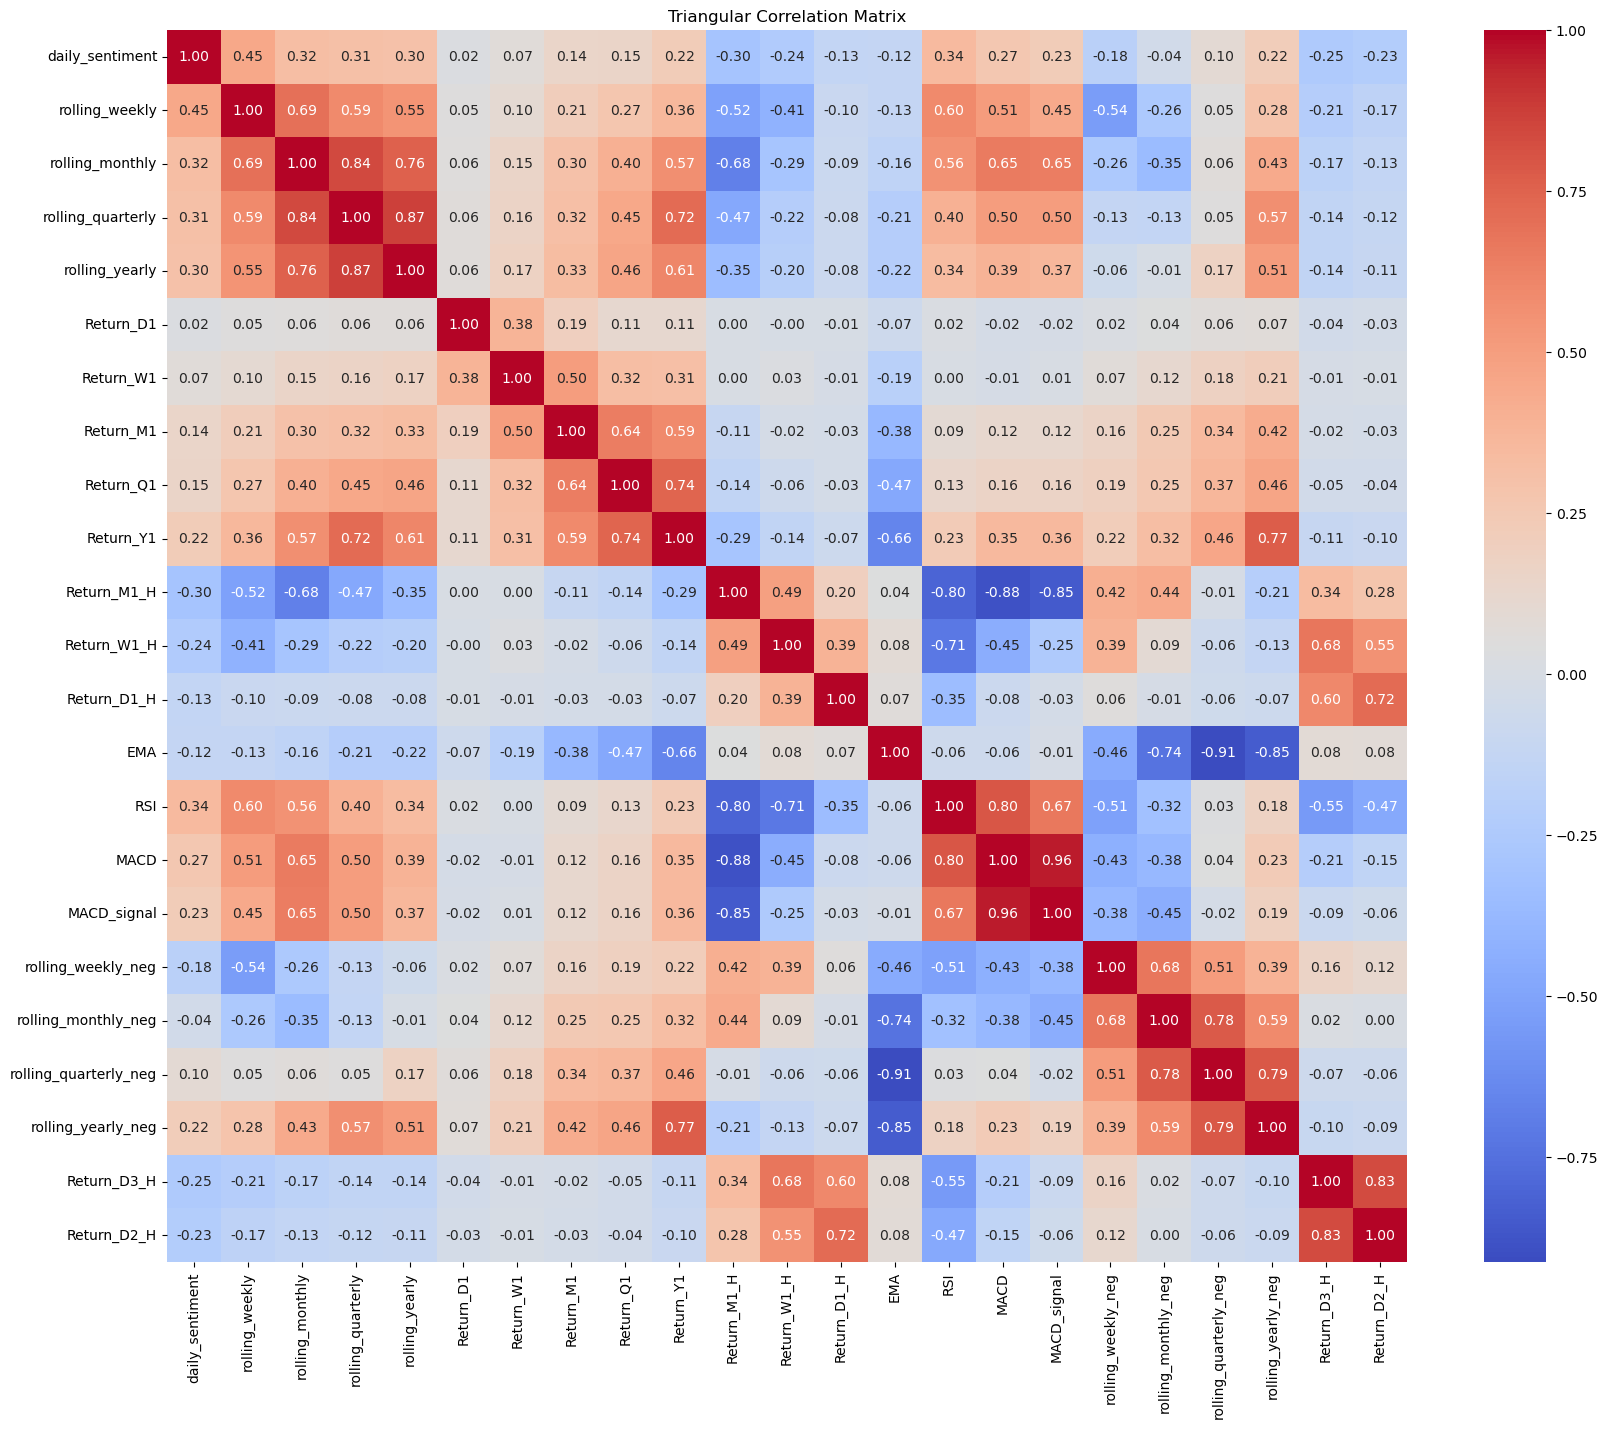

In [282]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#define variables for correlation matrix
variables = [
    "daily_sentiment", "rolling_weekly", "rolling_monthly", "rolling_quarterly", 
    "rolling_yearly", "Return_D1", "Return_W1", "Return_M1", 
    "Return_Q1", "Return_Y1", "Return_M1_H", "Return_W1_H", "Return_D1_H", "EMA", "RSI", "MACD", "MACD_signal",
    "rolling_weekly_neg", "rolling_monthly_neg", "rolling_quarterly_neg", "rolling_yearly_neg",
    "Return_D3_H", "Return_D2_H"
]

# Calculate the correlation matrix
correlation_matrix = merged_df[variables].corr()

# Create a mask to display only the lower triangle
#mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap with the mask
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Triangular Correlation Matrix")
plt.show()


### Testing Regression

In [224]:
#MAXIMAL MODEL NO POLYNOMIAL FEATURUES
import statsmodels.api as sm
import pandas as pd

# Features and targets
features = ['daily_sentiment', 'rolling_weekly', 'rolling_monthly', 'rolling_quarterly', 'rolling_yearly', "Return_M1_H", "Return_W1_H", "Return_D1_H", "EMA", "RSI", "MACD", "rolling_weekly_neg", "rolling_monthly_neg", "rolling_quarterly_neg", "rolling_yearly_neg", "count_monthly_total"]
targets = ['Return_M1', "Return_W1", "Return_D1"]

# Prepare results
for target in targets:
    # Add a constant to the features for the intercept term
    X = merged_df[features]
    X = sm.add_constant(X)  # Adds the intercept term
    y = merged_df[target]

    # Fit the regression model using statsmodels
    model = sm.OLS(y, X).fit()

    # Print the regression summary
    print(f"Regression Results for {target}:")
    print(model.summary())
    print("\n")


Regression Results for Return_M1:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     17.32
Date:                Tue, 14 Jan 2025   Prob (F-statistic):           2.37e-41
Time:                        21:26:04   Log-Likelihood:                 408.31
No. Observations:                 744   AIC:                            -782.6
Df Residuals:                     727   BIC:                            -704.2
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [212]:
#MINIMAL MODEL
import statsmodels.api as sm
import pandas as pd

# Features and targets
features = ['rolling_monthly',"rolling_monthly_neg", "Return_W1_H","count_monthly_total"]
targets = ['Return_M1'] #['Return_M1', "Return_W1", "Return_D1"]

# Prepare results
for target in targets:
    # Add a constant to the features for the intercept term
    X = merged_df[features]
    X = sm.add_constant(X)  # Adds the intercept term
    y = merged_df[target]

    # Fit the regression model using statsmodels
    model = sm.OLS(y, X).fit()

    # Print the regression summary
    print(f"Regression Results for {target}:")
    print(model.summary())
    print("\n")

Regression Results for Return_M1:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     78.92
Date:                Tue, 14 Jan 2025   Prob (F-statistic):           2.68e-44
Time:                        20:58:52   Log-Likelihood:                 391.42
No. Observations:                 744   AIC:                            -774.8
Df Residuals:                     740   BIC:                            -756.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------


In [221]:
#MAXIMAL MODEL WITH EVERY POLYNOMIAL FEATURE WITHOUT PLOT 
import statsmodels.api as sm
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

# Features and target
features = ['rolling_monthly', "rolling_monthly_neg", "Return_W1_H", "count_monthly_total", "EMA"]
target = 'Return_M1'  # Single target variable

# Add polynomial features (including interaction terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(merged_df[features])
poly_feature_names = poly.get_feature_names_out(features)

# Standardize feature names from PolynomialFeatures (replace spaces with `*`)
poly_feature_names = [name.replace(" ", "*") for name in poly_feature_names]
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=merged_df.index)

# Add manually created interaction terms (ensure consistent naming with `*`)
interactions = {
    '*'.join(combo): merged_df[combo[0]] * merged_df[combo[1]]
    for combo in combinations(features, 2)
}
interaction_df = pd.DataFrame(interactions)

# Combine original features, standardized polynomial features, and manual interaction terms
combined_features = pd.concat([merged_df[features], poly_df, interaction_df], axis=1)

# Remove duplicate columns (now standardized naming ensures true duplicates are detected)
combined_features = combined_features.loc[:, ~combined_features.columns.duplicated()]

# Add a constant term
X = sm.add_constant(combined_features)

# Define target variable
y = merged_df[target]

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print("Regression Results with Unique Terms:")
print(model.summary())


Regression Results with Unique Terms:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     25.54
Date:                Tue, 14 Jan 2025   Prob (F-statistic):           1.49e-70
Time:                        21:22:31   Log-Likelihood:                 486.99
No. Observations:                 744   AIC:                            -932.0
Df Residuals:                     723   BIC:                            -835.1
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

Regression Results with Unique Terms:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     25.54
Date:                Tue, 14 Jan 2025   Prob (F-statistic):           1.49e-70
Time:                        22:13:10   Log-Likelihood:                 486.99
No. Observations:                 744   AIC:                            -932.0
Df Residuals:                     723   BIC:                            -835.1
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

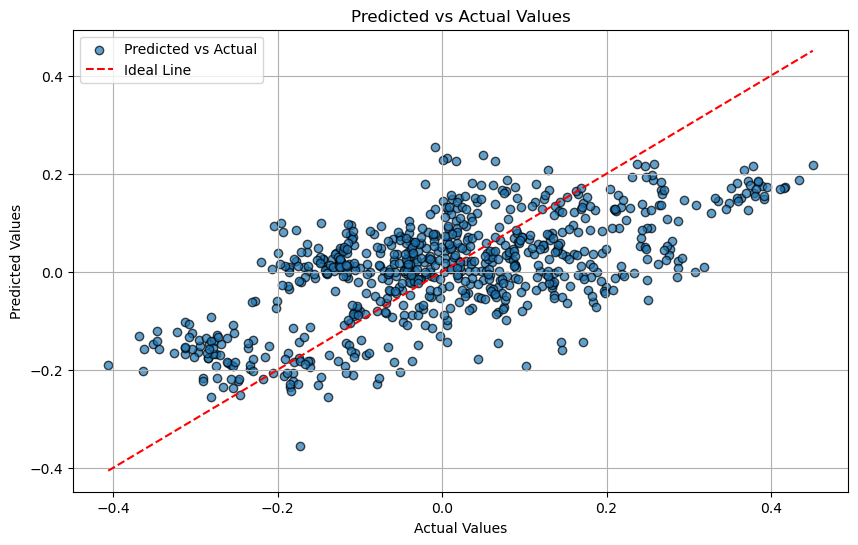

In [298]:
#MAXIMAL MODEL WITH EVERY POLYNOMIAL FEATURE WITH PLOT
import statsmodels.api as sm
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Features and target
features = ['rolling_monthly', "rolling_monthly_neg", "Return_W1_H", "count_monthly_total", "EMA", ]
target = 'Return_M1'  # Single target variable

# Add polynomial features (including interaction terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(merged_df[features])
poly_feature_names = poly.get_feature_names_out(features)

# Standardize feature names from PolynomialFeatures (replace spaces with `*`)
poly_feature_names = [name.replace(" ", "*") for name in poly_feature_names]
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=merged_df.index)

# Add manually created interaction terms (ensure consistent naming with `*`)
interactions = {
    '*'.join(combo): merged_df[combo[0]] * merged_df[combo[1]]
    for combo in combinations(features, 2)
}
interaction_df = pd.DataFrame(interactions)

# Combine original features, standardized polynomial features, and manual interaction terms
combined_features = pd.concat([merged_df[features], poly_df, interaction_df], axis=1)

# Remove duplicate columns (now standardized naming ensures true duplicates are detected)
combined_features = combined_features.loc[:, ~combined_features.columns.duplicated()]

# Add a constant term
X = sm.add_constant(combined_features)

# Define target variable
y = merged_df[target]

# Fit the regression model
model = sm.OLS(y, X).fit()

# Generate predictions
predictions = model.predict(X)

# Print the regression summary
print("Regression Results with Unique Terms:")
print(model.summary())

# Plot predictions against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y, predictions, alpha=0.7, edgecolor='k', label="Predicted vs Actual")
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal Line')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()

In [232]:
#MAXIMAL MODEL WITH KFOLDS AND NO PLOT
import statsmodels.api as sm
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Features and target
features = ['rolling_monthly', "rolling_monthly_neg", "Return_W1_H", "count_monthly_total", "EMA"]
target = 'Return_M1'  # Single target variable

# Add polynomial features (including interaction terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(merged_df[features])
poly_feature_names = poly.get_feature_names_out(features)

# Standardize feature names from PolynomialFeatures (replace spaces with `*`)
poly_feature_names = [name.replace(" ", "*") for name in poly_feature_names]
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=merged_df.index)

# Add manually created interaction terms (ensure consistent naming with `*`)
interactions = {
    '*'.join(combo): merged_df[combo[0]] * merged_df[combo[1]]
    for combo in combinations(features, 2)
}
interaction_df = pd.DataFrame(interactions)

# Combine original features, standardized polynomial features, and manual interaction terms
combined_features = pd.concat([merged_df[features], poly_df, interaction_df], axis=1)

# Remove duplicate columns (now standardized naming ensures true duplicates are detected)
combined_features = combined_features.loc[:, ~combined_features.columns.duplicated()]

# Add a constant term to combined features
X = sm.add_constant(combined_features)

# Define the target variable
y = merged_df[target]

# Initialize K-Fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare lists to store predictions, actual values, and R^2 scores
all_predictions = []
all_actuals = []
r2_scores = []

# Perform K-Fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Fit the model on the training data
    model = sm.OLS(y_train, X_train).fit()

    # Generate predictions on the test data
    predictions = model.predict(X_test)

    # Store predictions and actual values
    all_predictions.extend(predictions)
    all_actuals.extend(y_test)

    # Calculate and store R^2 for the current fold
    r2 = model.rsquared
    r2_scores.append(r2)

    # Print the regression summary for the current fold
    print(f"Fold {fold + 1} Regression Summary:")
    print(model.summary())
    print("\n")

# Calculate the average R^2 across all folds
average_r2 = sum(r2_scores) / len(r2_scores)
print(f"Average R^2 across all folds: {average_r2:.4f}")

Fold 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     22.71
Date:                Tue, 14 Jan 2025   Prob (F-statistic):           6.36e-60
Time:                        21:31:21   Log-Likelihood:                 398.04
No. Observations:                 595   AIC:                            -754.1
Df Residuals:                     574   BIC:                            -661.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [8]:
#RIDGE AND LASSO WITH KFOLDS + NNO PLOT + MINIMAL MODEL (WITH POLYNOMIALS AND INTERACTIONS THOUGH)
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score

# Features and target
features = ['rolling_monthly', "rolling_monthly_neg", "Return_W1_H", "count_monthly_total"] #"count_monthly_total", "EMA"
target = 'Return_M1'  # Single target variable

# Add polynomial features (including interaction terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(merged_df[features])
poly_feature_names = poly.get_feature_names_out(features)

# Standardize feature names from PolynomialFeatures (replace spaces with `*`)
poly_feature_names = [name.replace(" ", "*") for name in poly_feature_names]
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=merged_df.index)

# Add manually created interaction terms (ensure consistent naming with `*`)
interactions = {
    '*'.join(combo): merged_df[combo[0]] * merged_df[combo[1]]
    for combo in combinations(features, 2)
}
interaction_df = pd.DataFrame(interactions)

# Combine original features, standardized polynomial features, and manual interaction terms
combined_features = pd.concat([merged_df[features], poly_df, interaction_df], axis=1)

# Remove duplicate columns (now standardized naming ensures true duplicates are detected)
combined_features = combined_features.loc[:, ~combined_features.columns.duplicated()]

# Define the target variable
X = combined_features
y = merged_df[target]

# Initialize K-Fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare lists to store R^2 scores
lasso_r2_scores = []
ridge_r2_scores = []

# L1 Regularization (Lasso) and L2 Regularization (Ridge)
lasso_model = Lasso(alpha=0.1, max_iter=100000)  # Alpha controls regularization strength
ridge_model = Ridge(alpha=0.1)  # Alpha controls regularization strength

# Perform K-Fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Fit Lasso model (L1 regularization) and calculate R^2
    lasso_model.fit(X_train, y_train)
    lasso_predictions = lasso_model.predict(X_test)
    lasso_r2 = r2_score(y_test, lasso_predictions)
    lasso_r2_scores.append(lasso_r2)

    # Fit Ridge model (L2 regularization) and calculate R^2
    ridge_model.fit(X_train, y_train)
    ridge_predictions = ridge_model.predict(X_test)
    ridge_r2 = r2_score(y_test, ridge_predictions)
    ridge_r2_scores.append(ridge_r2)

    # Print fold-specific results
    print(f"Fold {fold + 1} Results:")
    print(f"Lasso R^2: {lasso_r2:.4f}")
    print(f"Ridge R^2: {ridge_r2:.4f}")
    print("\n")

# Calculate average R^2 scores across all folds
average_lasso_r2 = sum(lasso_r2_scores) / len(lasso_r2_scores)
average_ridge_r2 = sum(ridge_r2_scores) / len(ridge_r2_scores)

print(f"Average Lasso R^2 across all folds: {average_lasso_r2:.4f}")
print(f"Average Ridge R^2 across all folds: {average_ridge_r2:.4f}")


Fold 1 Results:
Lasso R^2: 0.0882
Ridge R^2: 0.0876


Fold 2 Results:
Lasso R^2: 0.0612
Ridge R^2: 0.0638


Fold 3 Results:
Lasso R^2: 0.0619
Ridge R^2: 0.0629


Fold 4 Results:
Lasso R^2: 0.0387
Ridge R^2: 0.0342


Fold 5 Results:
Lasso R^2: 0.1109
Ridge R^2: 0.1129


Average Lasso R^2 across all folds: 0.0722
Average Ridge R^2 across all folds: 0.0723


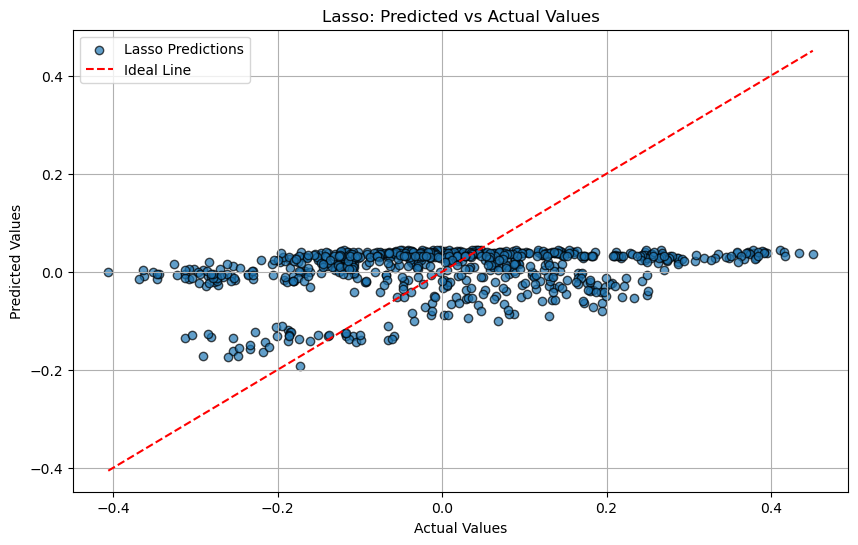

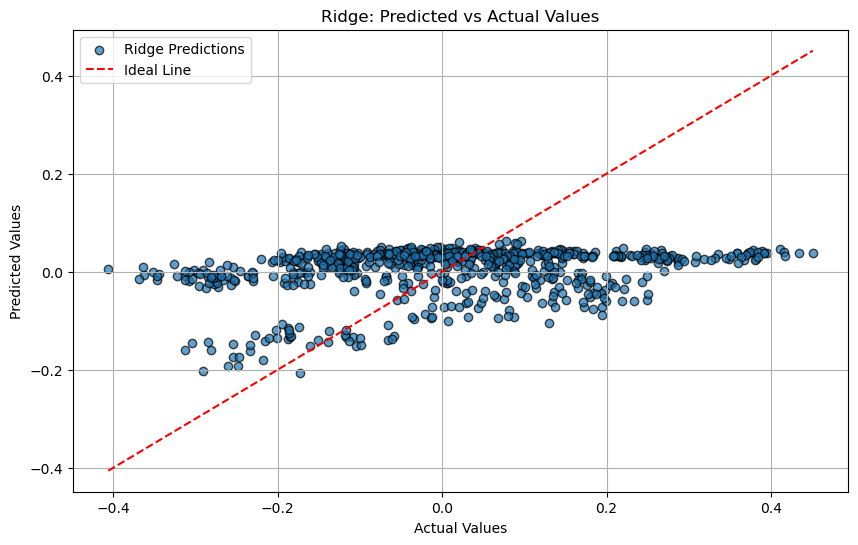

In [7]:
#RIDGE AND LASSO WITH KFOLDS +  PLOT + MINIMAL MODEL (WITH POLYNOMIALS AND INTERACTIONS THOUGH)
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Features and target
features = ['rolling_monthly', "rolling_monthly_neg", "Return_W1_H", "count_monthly_total"]  # "count_monthly_total", "EMA"
target = 'Return_M1'  # Single target variable

# Add polynomial features (including interaction terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(merged_df[features])
poly_feature_names = poly.get_feature_names_out(features)

# Standardize feature names from PolynomialFeatures (replace spaces with `*`)
poly_feature_names = [name.replace(" ", "*") for name in poly_feature_names]
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=merged_df.index)

# Add manually created interaction terms (ensure consistent naming with `*`)
interactions = {
    '*'.join(combo): merged_df[combo[0]] * merged_df[combo[1]]
    for combo in combinations(features, 2)
}
interaction_df = pd.DataFrame(interactions)

# Combine original features, standardized polynomial features, and manual interaction terms
combined_features = pd.concat([merged_df[features], poly_df, interaction_df], axis=1)

# Remove duplicate columns (now standardized naming ensures true duplicates are detected)
combined_features = combined_features.loc[:, ~combined_features.columns.duplicated()]

# Define the target variable
X = combined_features
y = merged_df[target]

# Initialize K-Fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare lists to store predictions and actual values for both Lasso and Ridge
lasso_predictions_all = []
ridge_predictions_all = []
actual_values_all = []

# L1 Regularization (Lasso) and L2 Regularization (Ridge)
lasso_model = Lasso(alpha=0.1, max_iter=100000)  # Alpha controls regularization strength
ridge_model = Ridge(alpha=0.1)  # Alpha controls regularization strength

# Perform K-Fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Fit Lasso model (L1 regularization)
    lasso_model.fit(X_train, y_train)
    lasso_predictions = lasso_model.predict(X_test)
    lasso_predictions_all.extend(lasso_predictions)
    
    # Fit Ridge model (L2 regularization)
    ridge_model.fit(X_train, y_train)
    ridge_predictions = ridge_model.predict(X_test)
    ridge_predictions_all.extend(ridge_predictions)
    
    # Store actual values for plotting
    actual_values_all.extend(y_test)

# Convert lists to Pandas Series for easy handling
actual_values_all = pd.Series(actual_values_all, name="Actual")
lasso_predictions_all = pd.Series(lasso_predictions_all, name="Lasso Predictions")
ridge_predictions_all = pd.Series(ridge_predictions_all, name="Ridge Predictions")

# Plot: Lasso Predictions vs Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(actual_values_all, lasso_predictions_all, alpha=0.7, edgecolor='k', label="Lasso Predictions")
plt.plot([actual_values_all.min(), actual_values_all.max()],
         [actual_values_all.min(), actual_values_all.max()], color='red', linestyle='--', label='Ideal Line')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso: Predicted vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()

# Plot: Ridge Predictions vs Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(actual_values_all, ridge_predictions_all, alpha=0.7, edgecolor='k', label="Ridge Predictions")
plt.plot([actual_values_all.min(), actual_values_all.max()],
         [actual_values_all.min(), actual_values_all.max()], color='red', linestyle='--', label='Ideal Line')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge: Predicted vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()


In [228]:
#MEDIUM MODEL ALL SIGNIFICANT FEAUTURES POLYNOMIALS/INTERACTIONS (NOT COMPLETE)
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

# Features and target
features = ['rolling_monthly', "rolling_monthly_neg", "count_monthly_total", "EMA"]
target = 'Return_M1'  # Single target variable

# Add interaction terms
interaction_terms = {
    "rolling_monthly*rolling_monthly_neg": merged_df["rolling_monthly"] * merged_df["rolling_monthly_neg"],
    "rolling_monthly*EMA": merged_df["rolling_monthly"] * merged_df["EMA"],
    "rolling_monthly_neg*EMA": merged_df["rolling_monthly_neg"] * merged_df["EMA"]
}

interaction_df = pd.DataFrame(interaction_terms)

# Add polynomial features (squared terms)
squared_terms = {
    "rolling_monthly^2": merged_df["rolling_monthly"] ** 2,
    "count_monthly_total^2": merged_df["count_monthly_total"] ** 2,
    "EMA^2": merged_df["EMA"] ** 2
}

squared_df = pd.DataFrame(squared_terms)

# Combine selected features, interaction terms, and polynomial features
selected_features_df = pd.concat([merged_df[features], interaction_df, squared_df], axis=1)

# Add a constant term
X = sm.add_constant(selected_features_df)

# Define target variable
y = merged_df[target]

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print("Regression Results with Selected Features:")
print(model.summary())


Regression Results with Selected Features:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     36.82
Date:                Tue, 14 Jan 2025   Prob (F-statistic):           1.64e-58
Time:                        21:28:06   Log-Likelihood:                 439.56
No. Observations:                 744   AIC:                            -857.1
Df Residuals:                     733   BIC:                            -806.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [227]:
# MINIMAL MODEL WITH KFOLDS
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import KFold

# Features and target
features = ['rolling_monthly', "rolling_monthly_neg", "Return_W1_H",]
target = 'Return_M1'  # Single target variable for cross-validation

# Initialize K-Fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare for storing fold results
fold_results = []

# Perform K-Fold Cross-Validation
for fold, (train_idx, test_idx) in enumerate(kf.split(merged_df)):
    # Split the data into train and test for this fold
    train_data = merged_df.iloc[train_idx]
    test_data = merged_df.iloc[test_idx]

    # Define X and y for this fold
    X_train = train_data[features]
    X_train = sm.add_constant(X_train)  # Adds the intercept term
    y_train = train_data[target]

    X_test = test_data[features]
    X_test = sm.add_constant(X_test)
    y_test = test_data[target]

    # Fit the regression model using statsmodels on training data
    model = sm.OLS(y_train, X_train).fit()

    # Evaluate the model on the test set
    predictions = model.predict(X_test)

    # Store fold results
    fold_results.append({
        'fold': fold + 1,
        'r_squared': model.rsquared,
        'summary': model.summary()
    })

    # Print results for this fold
    print(f"Regression Results for Fold {fold + 1}:")
    print(model.summary())
    print("\n")

# Summary of results
print("K-Fold Cross-Validation Completed:")
for result in fold_results:
    print(f"Fold {result['fold']} - R-squared: {result['r_squared']:.4f}")

Regression Results for Fold 1:
                            OLS Regression Results                            
Dep. Variable:              Return_M1   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     67.56
Date:                Tue, 14 Jan 2025   Prob (F-statistic):           1.42e-37
Time:                        21:27:49   Log-Likelihood:                 312.37
No. Observations:                 595   AIC:                            -616.7
Df Residuals:                     591   BIC:                            -599.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
con

In [176]:
#BINARY MODEL DIDNT GO WELL HAHA
# Features and binary targets
features = ['rolling_monthly', 'EMA']
binary_targets = ['Return_M1_indicator', 'Return_W1_indicator', 'Return_D1_indicator']

# Prepare results for logistic regression
for target in binary_targets:
    # Add a constant to the features for the intercept term
    X = merged_df[features]
    X = sm.add_constant(X)  # Adds the intercept term
    y = merged_df[target]

    # Fit the logistic regression model using statsmodels
    model = sm.Logit(y, X).fit()

    # Print the logistic regression summary
    print(f"Logistic Regression Results for {target}:")
    print(model.summary())
    print("\n")


Optimization terminated successfully.
         Current function value: 0.645632
         Iterations 5
Logistic Regression Results for Return_M1_indicator:
                            Logit Regression Results                           
Dep. Variable:     Return_M1_indicator   No. Observations:                  737
Model:                           Logit   Df Residuals:                      734
Method:                            MLE   Df Model:                            2
Date:                 Tue, 14 Jan 2025   Pseudo R-squ.:                 0.06840
Time:                         20:31:57   Log-Likelihood:                -475.83
converged:                        True   LL-Null:                       -510.77
Covariance Type:             nonrobust   LLR p-value:                 6.717e-16
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2321      0.515

## Alternative method with smaller sample size

In [141]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

def analyze_bitcoin_sentiment_regression(dates, sentiment_scores, article_count, minimum_articles):
    """
    Performs linear regression analysis between sentiment scores and Bitcoin returns.

    Parameters:
    - dates (list of str): List of dates in 'YYYY-MM-DD' format.
    - sentiment_scores (list of int): Corresponding sentiment scores (-1, 0, 1).
    - article_count (list of int): Number of articles for each sentiment score.
    - minimum_articles (int): Minimum number of articles required for a date to be included.

    Returns:
    - dict: Regression results (coefficients, intercepts, R², MSE) for next day, next week, next month, next quarter, and next year returns.
    """
    
    # Load bitcoin prices
    bitcoin_prices = pd.read_csv('bitcoin_data.csv')

    # Convert the date column to date instead of datetime
    bitcoin_prices['Date'] = pd.to_datetime(bitcoin_prices['Date']).dt.date

    # Add future return columns
    bitcoin_prices['Return_D1'] = bitcoin_prices['Price'].shift(-1) / bitcoin_prices['Price'] - 1
    bitcoin_prices['Return_W1'] = bitcoin_prices['Price'].shift(-7) / bitcoin_prices['Price'] - 1
    bitcoin_prices['Return_M1'] = bitcoin_prices['Price'].shift(-30) / bitcoin_prices['Price'] - 1
    bitcoin_prices['Return_Q1'] = bitcoin_prices['Price'].shift(-90) / bitcoin_prices['Price'] - 1
    bitcoin_prices['Return_Y1'] = bitcoin_prices['Price'].shift(-365) / bitcoin_prices['Price'] - 1

    if len(dates) != len(sentiment_scores) or len(dates) != len(article_count):
        print("Error: The number of dates, sentiment scores, and article counts must be equal.")
        return

    # Create DataFrame from dates and sentiment scores
    sentiment_df = pd.DataFrame({
        'Date': dates,
        'Sentiment': sentiment_scores,
        'article_count': article_count
    })

    # Filter rows with sufficient articles
    sentiment_df = sentiment_df[sentiment_df['article_count'] >= minimum_articles]

    # Merge with bitcoin_prices DataFrame on Date
    merged_df = pd.merge(sentiment_df, bitcoin_prices, on='Date', how='inner')

    if merged_df.empty:
        print("No overlapping data between sentiment and Bitcoin prices.")
        return

    # Perform linear regression for each return period
    regression_results = {}
    return_periods = {
        'Return_D1': 'Next Day',
        'Return_W1': 'Next Week',
        'Return_M1': 'Next Month',
        'Return_Q1': 'Next Quarter',
        'Return_Y1': 'Next Year'
    }

    for period, label in return_periods.items():
        # Select relevant columns and drop NaNs for the current period
        df_period = merged_df[['Sentiment', period]].dropna()

        if not df_period.empty:
            # Extract features (X) and target (y)
            X = df_period[['Sentiment']]
            y = df_period[period]

            # Perform linear regression
            model = LinearRegression()
            model.fit(X, y)

            # Predictions and metrics
            y_pred = model.predict(X)
            mse = mean_squared_error(y, y_pred)
            r2 = r2_score(y, y_pred)

            # Store results
            regression_results[period] = {
                'model': model,
                'coefficient': model.coef_[0],
                'intercept': model.intercept_,
                'r2_score': r2,
                'mse': mse
            }

            # Print results for this period
            print(f"Linear Regression for {label}:")
            print(f"  - Coefficient: {model.coef_[0]:.4f}")
            print(f"  - Intercept: {model.intercept_:.4f}")
            print(f"  - R² Score: {r2:.4f}")
            print(f"  - Mean Squared Error (MSE): {mse:.4f}")
            print("")

        else:
            print(f"Linear Regression for {label}: No data available.")
            regression_results[period] = None

    return regression_results

minimum_articles = 10

print("Monthly Results")
analyze_bitcoin_sentiment_regression(
    monthly_sentiment['Date'],
    monthly_sentiment['percent_positive'],
    monthly_sentiment['article_count'],
    minimum_articles
)
print("")

print("Weekly Results")
analyze_bitcoin_sentiment_regression(
    weekly_sentiment['Date'],
    weekly_sentiment['percent_positive'],
    weekly_sentiment['article_count'],
    minimum_articles
)
print("")

print("Daily Results")
analyze_bitcoin_sentiment_regression(
    daily_sentiment['Date'],
    daily_sentiment['percent_positive'],
    daily_sentiment['article_count'],
    minimum_articles
)
print("")

Monthly Results
Linear Regression for Next Day:
  - Coefficient: 0.0008
  - Intercept: -0.0308
  - R² Score: 0.0863
  - Mean Squared Error (MSE): 0.0005

Linear Regression for Next Week:
  - Coefficient: 0.0027
  - Intercept: -0.1028
  - R² Score: 0.1003
  - Mean Squared Error (MSE): 0.0045

Linear Regression for Next Month:
  - Coefficient: 0.0042
  - Intercept: -0.1415
  - R² Score: 0.0492
  - Mean Squared Error (MSE): 0.0241

Linear Regression for Next Quarter:
  - Coefficient: 0.0105
  - Intercept: -0.2899
  - R² Score: 0.0768
  - Mean Squared Error (MSE): 0.0942

Linear Regression for Next Year:
  - Coefficient: 0.0800
  - Intercept: -2.0301
  - R² Score: 0.3978
  - Mean Squared Error (MSE): 0.3636


Weekly Results
Linear Regression for Next Day:
  - Coefficient: 0.0005
  - Intercept: -0.0163
  - R² Score: 0.0161
  - Mean Squared Error (MSE): 0.0014

Linear Regression for Next Week:
  - Coefficient: 0.0010
  - Intercept: -0.0372
  - R² Score: 0.0186
  - Mean Squared Error (MSE): 0

## LSTM MODEL

c:\Users\laure\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Fold 1 Results: R^2: 0.2566, MSE: 0.0185, RMSE: 0.1359, MAPE: 3.2356


c:\Users\laure\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Fold 2 Results: R^2: 0.2576, MSE: 0.0177, RMSE: 0.1329, MAPE: 2.3443


c:\Users\laure\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Fold 3 Results: R^2: 0.3573, MSE: 0.0205, RMSE: 0.1432, MAPE: 1.2563


c:\Users\laure\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Fold 4 Results: R^2: 0.3327, MSE: 0.0170, RMSE: 0.1304, MAPE: 1.4796


c:\Users\laure\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Fold 5 Results: R^2: 0.3044, MSE: 0.0196, RMSE: 0.1401, MAPE: 5.5381

LSTM Model Performance Summary:
Overall R^2: 0.3087
Overall MSE: 0.0187
Overall RMSE: 0.1366
Overall MAPE: 2.7671


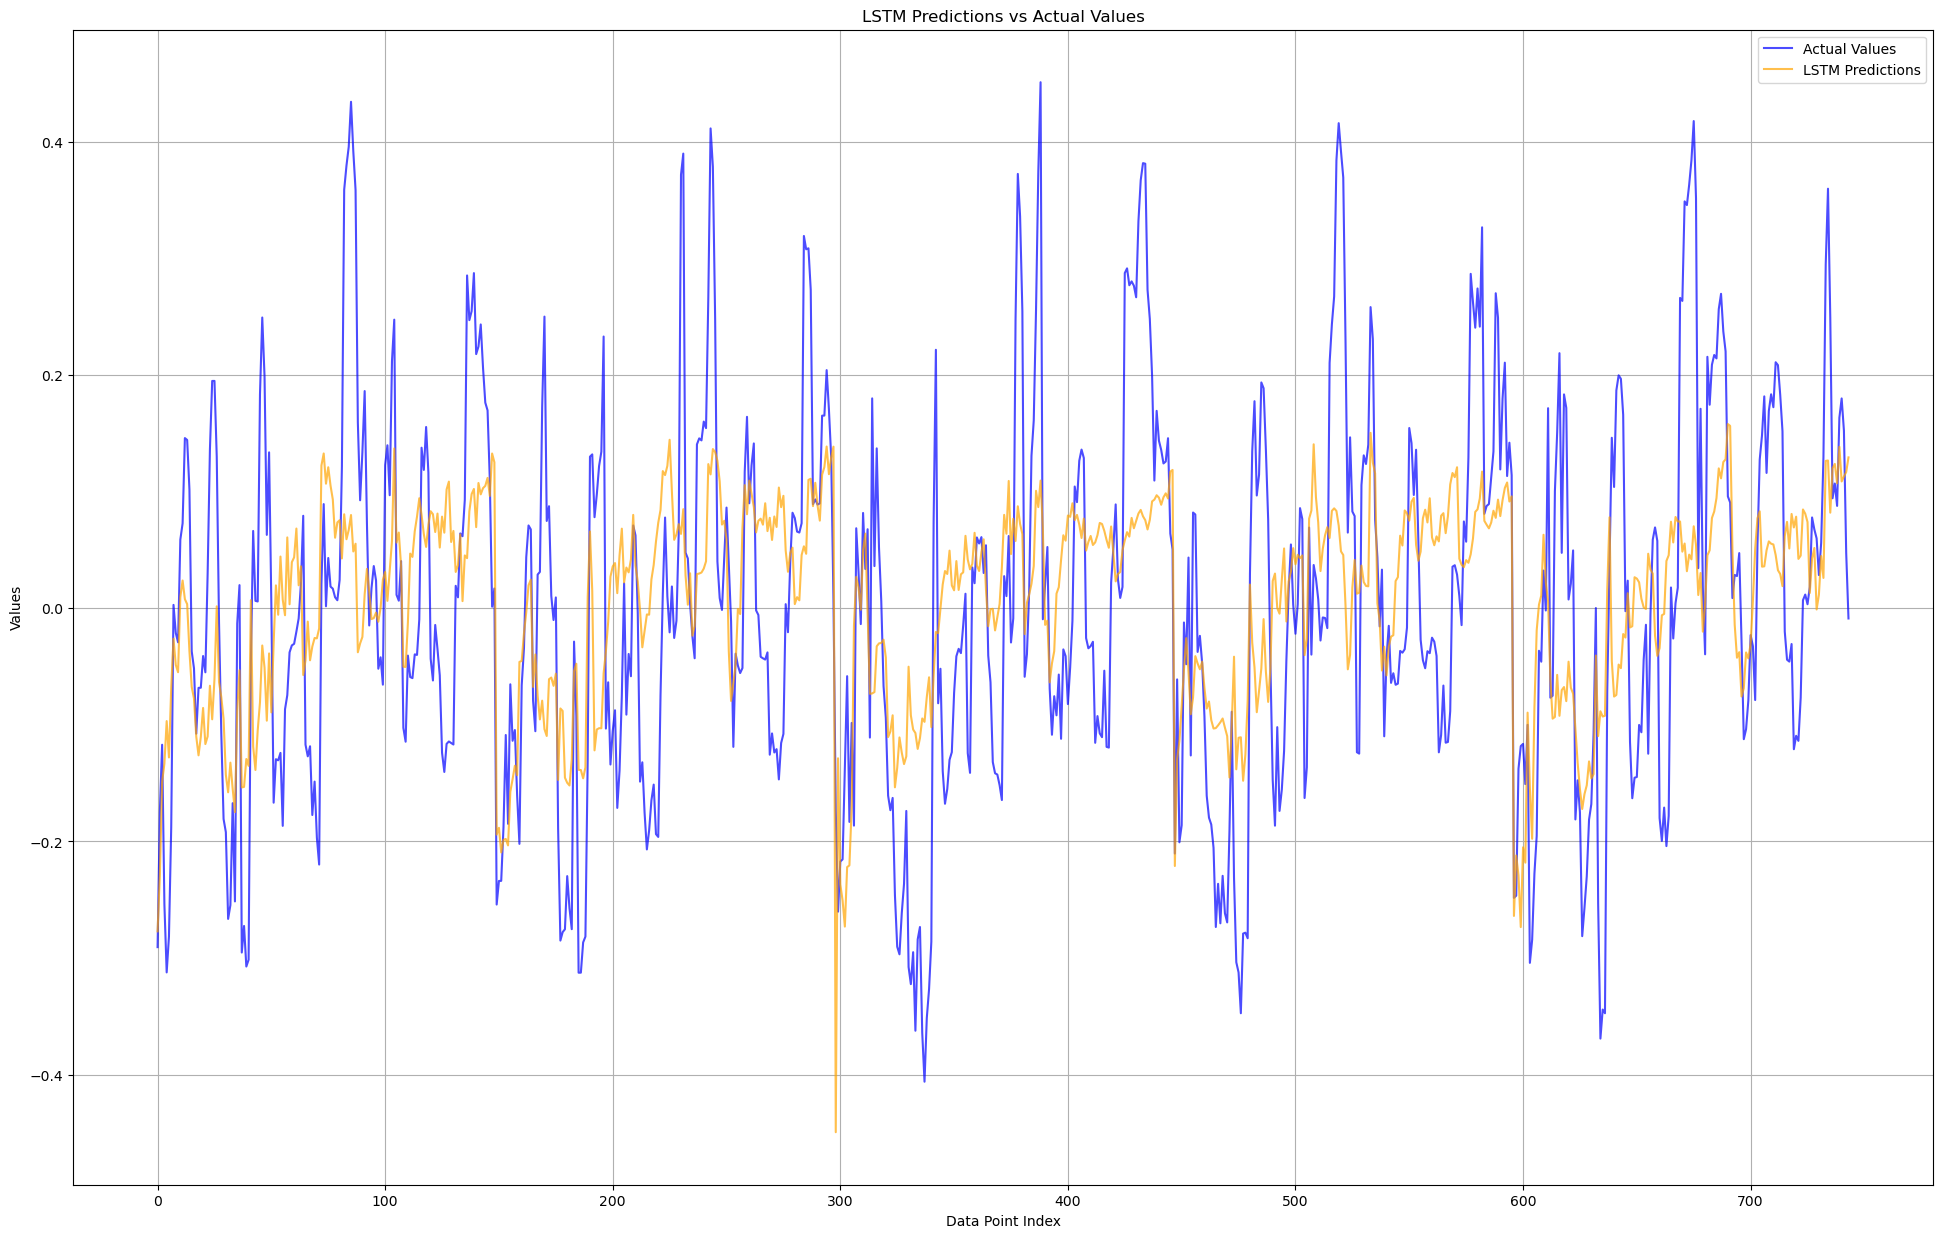

In [249]:
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

# Features and target
features = ['rolling_monthly', "rolling_monthly_neg", "Return_W1_H", "count_monthly_total"]
target = 'Return_M1'  # Single target variable

# Define the target variable
X = merged_df[features]
y = merged_df[target]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize K-Fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare lists to store predictions and actual values
lstm_predictions_all = []
actual_values_all = []

# Define LSTM model structure
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)  # Single output for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Perform K-Fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
    # Split the data into training and testing sets
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx].values, y.iloc[test_idx].values

    # Reshape the data for LSTM (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Create and train the LSTM model
    lstm_model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Generate predictions
    lstm_predictions = lstm_model.predict(X_test).flatten()
    lstm_predictions_all.extend(lstm_predictions)

    # Store actual values
    actual_values_all.extend(y_test)

    # Calculate metrics for the current fold
    r2 = r2_score(y_test, lstm_predictions)
    mse = mean_squared_error(y_test, lstm_predictions)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, lstm_predictions)

    print(f"Fold {fold + 1} Results: R^2: {r2:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}")

# Calculate overall performance metrics
r2_lstm = r2_score(actual_values_all, lstm_predictions_all)
mse_lstm = mean_squared_error(actual_values_all, lstm_predictions_all)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = mean_absolute_percentage_error(actual_values_all, lstm_predictions_all)

print("\nLSTM Model Performance Summary:")
print(f"Overall R^2: {r2_lstm:.4f}")
print(f"Overall MSE: {mse_lstm:.4f}")
print(f"Overall RMSE: {rmse_lstm:.4f}")
print(f"Overall MAPE: {mape_lstm:.4f}")

# Plot LSTM predicted values against actual values
plt.figure(figsize=(24, 15))
plt.plot(actual_values_all, label="Actual Values", color='blue', alpha=0.7)
plt.plot(lstm_predictions_all, label="LSTM Predictions", color='orange', alpha=0.7)
plt.xlabel("Data Point Index")
plt.ylabel("Values")
plt.title("LSTM Predictions vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()

In [286]:
merged_df

,Date,daily_sentiment,rolling_weekly,rolling_monthly,rolling_quarterly,rolling_yearly,count_weekly,count_monthly,count_quarterly,count_yearly,...,Return_M1_H,Return_W1_H,Return_D3_H,Return_D2_H,Return_D1_H,EMA,RSI,MACD,MACD_signal,count_monthly_total
0,2021-11-06,0.000000,33.333333,33.333333,33.333333,33.333333,6.0,6.0,6.0,6.0,...,-0.217747,-0.017411,-0.002072,-0.001557,-0.004388,60016.550131,58.033341,2008.863058,2553.183273,12.0
1,2021-11-08,0.000000,20.000000,20.000000,20.000000,20.000000,10.0,10.0,10.0,10.0,...,-0.239150,-0.103711,-0.095122,-0.091133,-0.069627,60992.561525,70.087283,2363.952236,2428.455794,20.0
2,2021-11-09,25.000000,21.428571,21.428571,21.428571,21.428571,14.0,14.0,14.0,14.0,...,-0.182224,-0.074146,-0.086521,-0.064905,0.005075,61592.521152,68.886430,2586.945280,2460.153691,28.0
3,2021-11-10,25.000000,22.222222,22.222222,22.222222,22.222222,18.0,18.0,18.0,18.0,...,-0.170976,-0.054227,-0.029837,0.042767,0.037502,61903.688099,60.884951,2538.139376,2475.750828,36.0
4,2021-11-11,0.000000,18.181818,18.181818,18.181818,18.181818,22.0,22.0,22.0,22.0,...,-0.168650,-0.058665,0.037339,0.032101,-0.005205,62217.543223,61.555954,2498.050537,2480.210770,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2023-12-06,62.500000,54.545455,46.060606,43.824405,39.157941,154.0,495.0,1344.0,4584.0,...,-0.199290,-0.142046,-0.104118,-0.067744,0.008646,38829.758409,81.436187,1784.136423,1249.065961,990.0
740,2023-12-07,38.709677,53.459119,45.436893,43.873808,39.182431,159.0,515.0,1363.0,4599.0,...,-0.183161,-0.129803,-0.055848,0.021517,0.012761,39253.147513,76.808856,1917.037268,1382.660223,1030.0
741,2023-12-08,50.000000,54.140127,45.841393,43.921852,39.270992,157.0,517.0,1382.0,4609.0,...,-0.195631,-0.136299,-0.005021,-0.013551,-0.025980,39746.143960,79.438765,2091.393499,1524.406878,1034.0
742,2023-12-09,50.000000,52.201258,46.031746,44.051911,39.239957,159.0,504.0,1387.0,4605.0,...,-0.170982,-0.122524,-0.005997,-0.018522,0.007657,40160.034716,76.699042,2177.231724,1654.971847,1008.0



Simple Moving Average (SMA) Baseline Performance:
R^2: -0.4415
MSE: 0.0012
RMSE: 0.0350
MAPE: 4.1036


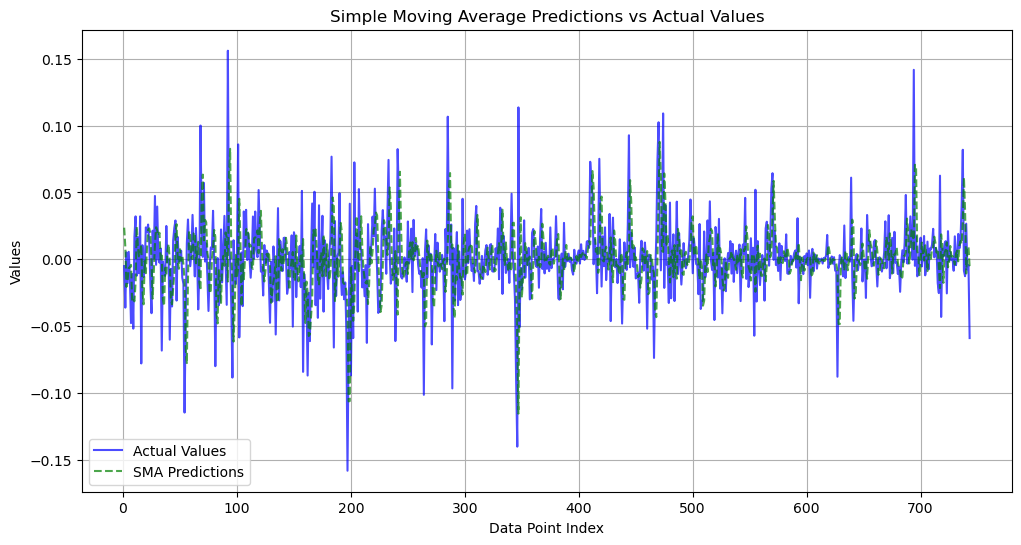

In [296]:
# Define a window size for the simple moving average
window_size = 2 # Number of past values to consider for the moving average

# Calculate the SMA predictions (using only past values)
actual_values_series = pd.Series(merged_df["Return_D1"])
sma_predictions = actual_values_series.shift(1).rolling(window=window_size, min_periods=1).mean()

# Drop the first `window_size` values (NaN or invalid for prediction)
valid_indices = ~sma_predictions.isna()  # Ensure valid SMA predictions
sma_predictions = sma_predictions[valid_indices]
valid_actual_values = actual_values_series[valid_indices]

# Calculate overall metrics for SMA
sma_r2 = r2_score(valid_actual_values, sma_predictions)
sma_mse = mean_squared_error(valid_actual_values, sma_predictions)
sma_rmse = np.sqrt(sma_mse)
sma_mape = mean_absolute_percentage_error(valid_actual_values, sma_predictions)

# Print SMA performance summary
print("\nSimple Moving Average (SMA) Baseline Performance:")
print(f"R^2: {sma_r2:.4f}")
print(f"MSE: {sma_mse:.4f}")
print(f"RMSE: {sma_rmse:.4f}")
print(f"MAPE: {sma_mape:.4f}")

# Plot SMA predictions vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(valid_actual_values.index, valid_actual_values, label="Actual Values", color='blue', alpha=0.7)
plt.plot(valid_actual_values.index, sma_predictions, label="SMA Predictions", color='green', linestyle='--', alpha=0.7)
plt.xlabel("Data Point Index")
plt.ylabel("Values")
plt.title("Simple Moving Average Predictions vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()

In [275]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming `merged_df` contains the returns data and `target` is the current day return
returns = merged_df[target]

# Create a lagged feature (previous day's return)
returns_lagged = returns.shift(1)

# Drop the first row since it will have NaN after the shift
valid_data = pd.DataFrame({'Current Return': returns, 'Previous Return': returns_lagged}).dropna()

# Calculate the correlation
correlation, p_value = pearsonr(valid_data['Previous Return'], valid_data['Current Return'])

# Print results
print(f"Correlation between previous day's return and current day's return: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation of correlation
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")


Correlation between previous day's return and current day's return: 0.9698
P-value: 0.0000
The correlation is statistically significant.


## 